To get the mean or median NDVI by LULC or (LULC * TCC)

## Packages

In [7]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt

from rasterio.mask import mask
from rasterio import mask as rio_mask
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from rasterio.transform import array_bounds
from rasterstats import zonal_stats

from shapely.geometry import box
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import Normalize




# Set the working directory
wd = 'E:/_data/LULC/NLCD_USA/'
os.chdir(wd)


# Output directory
dir_output = 'D:/natcap/invest-mental-health/'

## Data

In [8]:
dir_shp = 'D:/natcap/invest-mental-health/data'

path_aoi = os.path.join(dir_shp, 'cb_2019_us_county_500k_06075_clip.shp')

path_ndvi_raster = 'D:/natcap/invest-mental-health/data/ndvi_s2_075_2019_10m_reprojected.tif'

## land cover only 
suffix = 'lc'
path_landcover = os.path.join('nlcd_2019_land_cover_l48_20210604', 'nlcd_2019_land_cover_l48_20210604.img')

## land cover * tcc
suffix = 'lc_tcc'
path_landcover = os.path.join('nlcd_2019_land_cover_l48_20210604', 'nlcd_2019_land_cover_l48_20210604_clipped_reclassified.tif')


### AOI

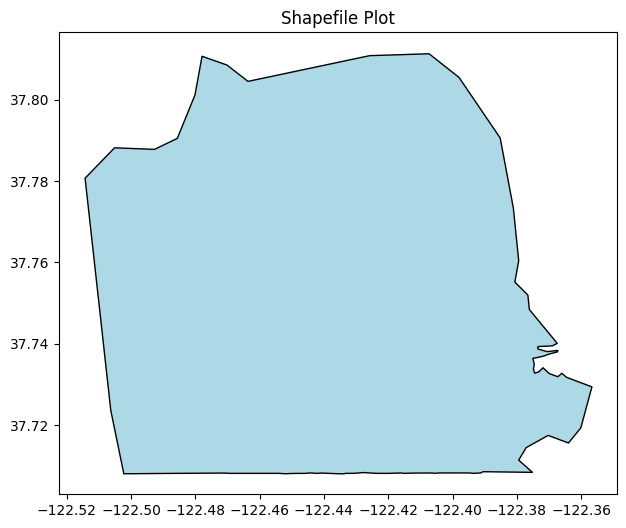

In [9]:
# Load the shapefile
aoi = gpd.read_file(path_aoi)

# Step 2: Plot the shapefile
fig, ax = plt.subplots(figsize=(10, 6))
aoi.plot(ax=ax, color='lightblue', edgecolor='black')

# Customize plot
ax.set_title("Shapefile Plot")
plt.show()

### NDVI

Reprojecting city boundary from EPSG:4269 to PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


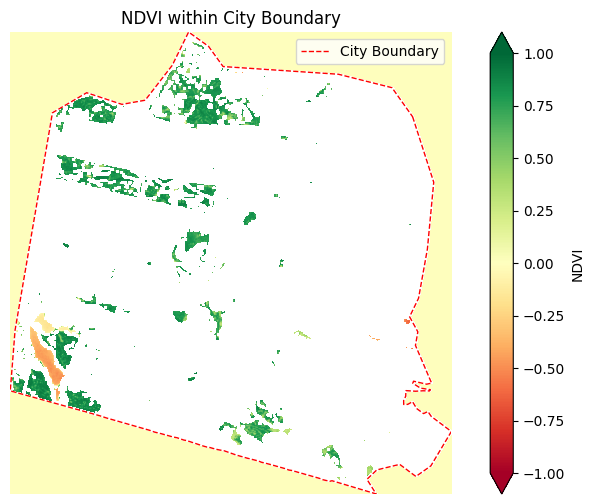

In [10]:
OUTPUT_NDVI = os.path.join(dir_output, 'figures/ndvi_map_aoi.png')

# Step 1: Load the NDVI raster

with rasterio.open(path_ndvi_raster) as ndvi_src:
    ndvi = ndvi_src.read(1)
    ndvi_crs = ndvi_src.crs
    ndvi_meta = ndvi_src.meta


aoi_region = aoi
if aoi_region.crs != ndvi_crs:
    print(f"Reprojecting city boundary from {aoi_region.crs} to {ndvi_crs}")
    aoi_region = aoi_region.to_crs(ndvi_crs)


# Step 3: Clip the NDVI raster using the reprojected AOI
aoi_geometry = [aoi_region.geometry.unary_union]



with rasterio.open(path_ndvi_raster) as src:
    ndvi_clipped, ndvi_clipped_transform = mask(src, aoi_geometry, crop=True)
    ndvi_clipped_meta = src.meta.copy()
    ndvi_clipped_meta.update({
        "driver": "GTiff",
        "height": ndvi_clipped.shape[1],
        "width": ndvi_clipped.shape[2],
        "transform": ndvi_clipped_transform
    })


# Step 6: Visualize the clipped NDVI with AOI and city boundary overlay
fig, ax = plt.subplots(figsize=(10, 6))
norm = Normalize(vmin=-1, vmax=1)
plt.imshow(ndvi_clipped[0], 
           cmap='RdYlGn', 
           norm=norm,
           extent=[
    ndvi_clipped_transform[2],  # x_min
    ndvi_clipped_transform[2] + ndvi_clipped_transform[0] * ndvi_clipped.shape[2],  # x_max
    ndvi_clipped_transform[5] + ndvi_clipped_transform[4] * ndvi_clipped.shape[1],  # y_min
    ndvi_clipped_transform[5]  # y_max
])
plt.colorbar(label='NDVI', extend='both')
aoi_region.boundary.plot(ax=ax, edgecolor='red', linewidth=1, linestyle='--', label='City Boundary')

# Customize the plot
ax.set_title('NDVI within City Boundary')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('off')
plt.legend()
plt.savefig(OUTPUT_NDVI, bbox_inches='tight', dpi=300)
plt.show()



## Process

### 1 - NDVI by LULC - deepseek

    NLCD_Code  Mean_NDVI
0         110  -0.255582
1         211   0.727476
2         212   0.787718
3         213   0.759506
4         221        NaN
5         222        NaN
6         223        NaN
7         230        NaN
8         240        NaN
9         311        NaN
10        312        NaN
11        313        NaN
12        411   0.837872
13        412   0.838130
14        413   0.667300
15        421   0.672613
16        422   0.727704
17        423   0.788736
18        431   0.643029
19        432   0.639893
20        433   0.760775
21        521   0.573061
22        522   0.642494
23        523   0.734958
24        711   0.544547
25        712   0.739285
26        713   0.757207
27        810   0.656254
28        820        NaN
29        901        NaN
30        902        NaN
31        903        NaN
32        950        NaN


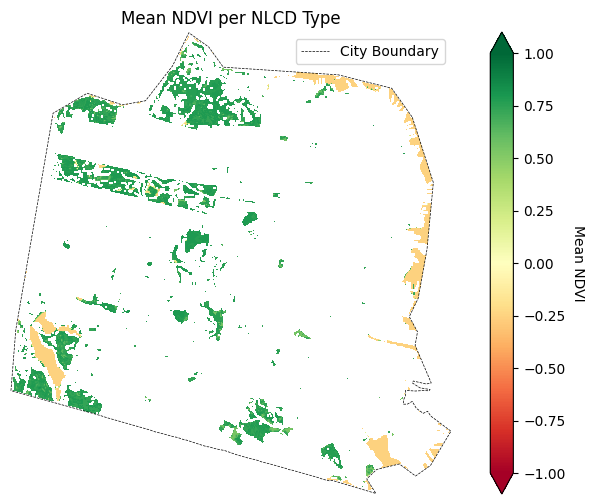

Processing complete!
CSV: D:/natcap/invest-mental-health/data/mean_ndvi_by_nlcd_lc_tcc.csv
Map: D:/natcap/invest-mental-health/figures/mean_ndvi_by_lulc_map_lc_tcc.png


In [11]:

# File paths (Update these with your actual paths)
BOUNDARY_FILE = path_aoi
NDVI_FILE = path_ndvi_raster
NLCD_FILE = path_landcover

OUTPUT_CSV = os.path.join(dir_output, 'data/mean_ndvi_by_nlcd_' + suffix +'.csv')
OUTPUT_IMAGE = os.path.join(dir_output, 'figures/mean_ndvi_by_lulc_map_' + suffix + '.png')


def clip_raster(raster_path, boundary_geom):
    """Clip raster to boundary geometry (in same CRS)"""
    with rasterio.open(raster_path) as src:
        out_image, out_transform = rio_mask.mask(src, [boundary_geom], crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        return out_image.squeeze(), out_meta

def align_ndvi_to_nlcd(ndvi_path, nlcd_meta):
    """Reproject NDVI to match clipped NLCD's specifications"""
    with rasterio.open(ndvi_path) as src:
        ndvi_reprojected = np.zeros((nlcd_meta['height'], nlcd_meta['width']), dtype=np.float32)
        
        reproject(
            source=rasterio.band(src, 1),
            destination=ndvi_reprojected,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=nlcd_meta['transform'],
            dst_crs=nlcd_meta['crs'],
            resampling=Resampling.bilinear,
            dst_nodata=np.nan
        )
    return ndvi_reprojected

def calculate_mean_ndvi(ndvi, nlcd_data, nlcd_nodata):
    """Calculate mean NDVI for each NLCD class present in the data"""
    # Get all unique NLCD classes (excluding nodata)
    valid_classes = np.unique(nlcd_data[(nlcd_data != nlcd_nodata) & (nlcd_data > 0)])
    
    # Calculate mean NDVI for each class
    results = {}
    for cls in valid_classes:
        mask = (nlcd_data == cls) & (~np.isnan(ndvi))
        if np.any(mask):
            results[cls] = np.nanmean(ndvi[mask])
        else:
            results[cls] = np.nan  # Class exists but has no valid NDVI
    return results

# Main processing
# 1. Load and prepare boundary geometry
boundary_gdf = gpd.read_file(BOUNDARY_FILE)
with rasterio.open(NLCD_FILE) as nlcd_src:
    boundary_proj = boundary_gdf.to_crs(nlcd_src.crs)
    boundary_geom = boundary_proj.geometry.values[0]

# 2. Clip NLCD to boundary
clipped_nlcd, nlcd_meta = clip_raster(NLCD_FILE, boundary_geom)
nlcd_nodata = nlcd_meta.get('nodata', 0)

# 3. Align and clip NDVI to match clipped NLCD
ndvi_aligned = align_ndvi_to_nlcd(NDVI_FILE, nlcd_meta)

# 4. Calculate statistics
mean_ndvi = calculate_mean_ndvi(ndvi_aligned, clipped_nlcd, nlcd_nodata)

# Generate outputs
# CSV with all NLCD codes present in the study area
output_df = pd.DataFrame({
    'NLCD_Code': list(mean_ndvi.keys()),
    'Mean_NDVI': list(mean_ndvi.values())
}).sort_values('NLCD_Code')

output_df.to_csv(OUTPUT_CSV, index=False)
print(output_df)

# Create choropleth map
plt.figure(figsize=(10, 6))
classified_ndvi = np.full_like(clipped_nlcd, np.nan, dtype=np.float32)
for cls, value in mean_ndvi.items():
    classified_ndvi[clipped_nlcd == cls] = value

transform = nlcd_meta['transform']
height = nlcd_meta['height']
width = nlcd_meta['width']
left, bottom, right, top = array_bounds(height, width, transform)

norm = Normalize(vmin=-1, vmax=1)
img = plt.imshow(
    classified_ndvi,
    cmap=plt.cm.RdYlGn,
    norm=norm,
    extent=[left, right, bottom, top],
    origin='upper'
)

# Add city boundary
boundary_proj.boundary.plot(
    ax=plt.gca(),
    edgecolor='black',
    linewidth=0.5,
    linestyle='--',
    label='City Boundary'
)

cbar = plt.colorbar(img, extend='both')
cbar.set_label('Mean NDVI', rotation=270, labelpad=14)
plt.title('Mean NDVI per NLCD Type')
plt.legend(loc='upper right')
plt.axis('off')

plt.savefig(OUTPUT_IMAGE, bbox_inches='tight', dpi=300)
plt.show()

print(f"Processing complete!\nCSV: {OUTPUT_CSV}\nMap: {OUTPUT_IMAGE}")

### 2 - NDVI by LULC - gpt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CSV file saved: mean_ndvi_by_land_cover.csv


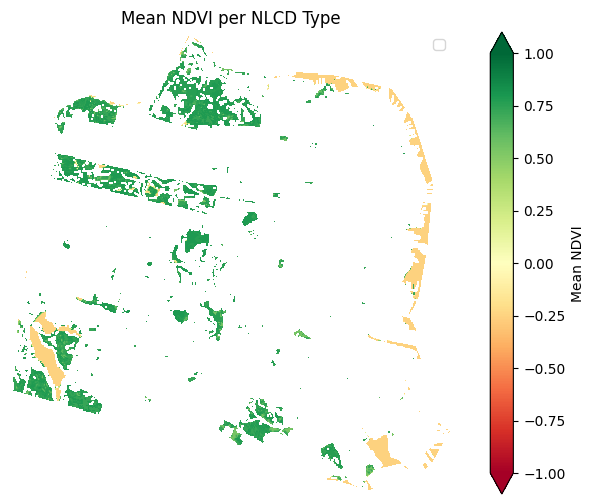

In [12]:
# Define file paths
nlcd_path = path_landcover   # Update with NLCD raster path
ndvi_path = path_ndvi_raster             # Update with NDVI raster path

OUTPUT_CSV = os.path.join(dir_output, 'data/mean_ndvi_by_nlcd2.csv')
OUTPUT_IMAGE = os.path.join(dir_output, 'figures/mean_ndvi_by_lulc_map2.png')

# Step 1: Load the San Francisco boundary (AOI)
sf_boundary = aoi_region

# Step 2: Function to clip and mask a raster
def clip_raster(raster_path, boundary):
    """Clips a raster to a given boundary and returns the clipped array and metadata."""
    with rasterio.open(raster_path) as src:
        boundary = [boundary.geometry.unary_union.__geo_interface__]  # Convert to GeoJSON format
        out_image, out_transform = rasterio.mask.mask(src, boundary, crop=True, nodata=src.nodata)
        out_meta = src.meta
        out_meta.update({"transform": out_transform, "width": out_image.shape[2], "height": out_image.shape[1]})
    return out_image[0], out_meta  # Return first band

# Clip the NLCD raster
nlcd_array, nlcd_meta = clip_raster(nlcd_path, sf_boundary)

# Step 3: Reproject and resample NDVI to match NLCD
def reproject_resample(src_raster_path, target_meta):
    """Reprojects and resamples a raster to match the target metadata."""
    with rasterio.open(src_raster_path) as src:
        # Read source data
        src_data = src.read(1)
        
        # Define the destination array with the target shape
        dest_data = np.empty((target_meta["height"], target_meta["width"]), dtype=np.float32)
        
        # Perform reprojection and resampling
        rasterio.warp.reproject(
            source=src_data,
            destination=dest_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_meta["transform"],
            dst_crs=target_meta["crs"],
            resampling=rasterio.enums.Resampling.bilinear  # Bilinear resampling for continuous data (NDVI)
        )
    return dest_data

# Reproject and resample NDVI raster
ndvi_array = reproject_resample(ndvi_path, nlcd_meta)

# Step 4: Ensure the NDVI and NLCD arrays have the same dimensions
if nlcd_array.shape != ndvi_array.shape:
    raise ValueError("Reprojection and resampling failed. Check raster resolutions and extents.")

# Step 5: Convert NDVI NoData values to NaN
ndvi_nodata_value = -9999  # Update this if NDVI NoData is different
ndvi_array[ndvi_array == ndvi_nodata_value] = np.nan

# Step 6: Calculate mean NDVI per land cover type, ensuring valid values exist
unique_classes = np.unique(nlcd_array[nlcd_array > 0])  # Get unique NLCD land cover types (excluding background 0)

mean_ndvi_by_class = []
for lc_class in unique_classes:
    mask = nlcd_array == lc_class  # Create a mask for current land cover type
    valid_ndvi = ndvi_array[mask]  # Extract NDVI values for this land cover type
    
    if np.any(~np.isnan(valid_ndvi)):  # Check if there are valid NDVI values
        mean_ndvi = np.nanmean(valid_ndvi)  # Use np.nanmean() to ignore NaN values
    else:
        mean_ndvi = None  # Set None explicitly if no valid NDVI values exist
    
    mean_ndvi_by_class.append((lc_class, mean_ndvi))

# Step 7: Convert results to DataFrame and save as CSV
df_results = pd.DataFrame(mean_ndvi_by_class, columns=["NLCD_Type", "Mean_NDVI"])

# Step 8: Save CSV while ensuring NA values are handled correctly
df_results.to_csv(OUTPUT_CSV, index=False, na_rep="NA")
print("CSV file saved: mean_ndvi_by_land_cover.csv")

# Step 9: Create a map of mean NDVI per NLCD type
ndvi_colormap = plt.cm.RdYlGn  # NDVI color scale (red=low, green=high)
ndvi_values = df_results.set_index("NLCD_Type")["Mean_NDVI"].to_dict()  # Convert DataFrame to dictionary

# Replace NLCD values with corresponding mean NDVI values
ndvi_by_land_cover = np.full_like(nlcd_array, np.nan, dtype=np.float32)  # Initialize with NaN
for lc_class, mean_ndvi in ndvi_values.items():
    if mean_ndvi is not None:  # Only assign if valid
        ndvi_by_land_cover[nlcd_array == lc_class] = mean_ndvi

# Step 10: Plot the mean NDVI by land cover type
plt.figure(figsize=(10, 6))
# plt.imshow(ndvi_by_land_cover, cmap=ndvi_colormap, interpolation='nearest')
norm = Normalize(vmin=-1, vmax=1)
plt.imshow(ndvi_by_land_cover, cmap=ndvi_colormap, norm=norm)
plt.colorbar(label="Mean NDVI", extend='both')
plt.title("Mean NDVI per NLCD Type")
plt.legend(loc='upper right')
plt.axis("off")  # Hide axis for better visualization
plt.savefig(OUTPUT_IMAGE, bbox_inches='tight', dpi=300)
plt.show()
